In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import h5py
from distancias import *
import os
from os.path import join
import scipy.io
from scipy.interpolate import PchipInterpolator
from scipy.signal.windows import tukey
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
import seaborn as sns
import umap #pip install umap-learn
import umap.plot
import hdbscan
from scipy.spatial.distance import cdist
from tqdm import tqdm
from sklearn.decomposition import PCA
import pywt
from scipy import stats
from scipy.stats import sem

C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
from scipy.optimize import least_squares
def exponencial(x, A, B, tau):
    return A*((np.exp(-(x/tau)))+B)
def residual(params, x, y):
    return exponencial(x, *params)-y

In [3]:
def waveclus(spikes, n_features=10):
    n_spikes = spikes.shape[0]

    
    c = pywt.wavedec(spikes[0, :], 'haar', level=4)
    coeffs= np.concatenate((c[0], c[1], c[2], c[3], c[4]))
    
    CoefsWL = np.zeros((n_spikes, len(coeffs)))
    for ii in range(n_spikes):
        C = pywt.wavedec(spikes[ii,:], 'haar', level=4)
        CoefsWL[ii,:] = np.concatenate((C[0], C[1], C[2], C[3], C[4]))
    Features = CoefsWL.copy()
    DimFeatures= np.shape(Features)[1]

    Ptest= np.zeros(DimFeatures)
    KSstat= np.zeros(DimFeatures)
    
    for ii in range(DimFeatures):
        pd =stats.norm.fit(Features[:,ii])  #Estima parametros mu y sigma de los datos, 
                                            #ajustandolos a la distribucion normal
        mu = pd[0]
        sigma = pd[1]
        if sigma != 0:  
            Data= (Features[:,ii]- mu)/ sigma  #Normalizacion Z-score
            KSstat[ii], Ptest[ii]= stats.kstest(Data, 'norm')  #KS test
            
        else:
            KSstat[ii], Ptest[ii]= np.zeros(1, dtype="float"), np.zeros(1, dtype='float')
            
    #Ordenamos (el menos normal va ultimo)
    OrderIndex = np.argsort(KSstat)
        
    spike_features = np.zeros((n_spikes, n_features))
    
    for ii in range(n_features):
        index= OrderIndex[DimFeatures - 1 - ii]  #index = OrderIndex(DimFeatures +1-ii);
        spike_features[:,ii] = Features[:, index]
    sf = spike_features.copy()
    return sf

In [4]:
def extractor(archivo_espigas, archivos_señales, tamaño_onda=30, threshold=None):
    ondasxespigaxelectrodo = []
    t_espigas = []
    with h5py.File(archivo_espigas, "r") as f:
        for i in range(len(f["spiketimes"])):
            señal = archivos_señales[i]
            tiempos_espigas = np.array(f["spiketimes"]["elec_" + str(i)])
            ondasxespiga = np.zeros((len(tiempos_espigas), 2*tamaño_onda+1))
            for j, k in enumerate(tiempos_espigas):
                ondasxespiga[j]=señal[int(k-tamaño_onda):int(k+tamaño_onda+1)]
            if threshold is not None:
                maximos = ondasxespiga[:, tamaño_onda]
                primer_tiempo = ondasxespiga[:, 0]
                ultimo_tiempo = ondasxespiga[:, -1]
                no_espigas = np.where((maximos<threshold[1]) | (primer_tiempo<=threshold[0]) | (ultimo_tiempo<=threshold[0] | (maximos>threshold[2])))[0]
                ondasxespigaxelectrodo.append(np.delete(ondasxespiga, no_espigas, 0))
                t_espigas.append(np.delete(tiempos_espigas, no_espigas))
            else:
                ondasxespigaxelectrodo.append(ondasxespiga)
    if threshold is not None:
        return t_espigas, ondasxespigaxelectrodo
    else:
        return ondasxespigaxelectrodo

In [5]:
def spike_aligner(
    spikes,
    upsample_rate=6,
    alignment="tukey",
    window_length=24,
    min_sample=7,
    alpha=0.35,
):
    n_sample_points = np.shape(spikes)[1]
    sample_points = np.arange(n_sample_points)
    dense_sample_points = np.arange(0, n_sample_points, 1 / upsample_rate)

    interpolator = PchipInterpolator(sample_points, spikes, axis=1)
    spikes_dense = interpolator(dense_sample_points)

    if alignment == "tukey":
        min_index = np.argmin(spikes_dense, axis=1)

        window = tukey(n_sample_points * upsample_rate, alpha=alpha)
        spikes_tukeyed = spikes_dense * window
        center = 12 * upsample_rate  # make this optional later

        spikes_aligned_dense = np.zeros(np.shape(spikes_tukeyed))

        # We apply circular shift to the spikes so that they are all aligned
        # to their respective minimums at the center point
        for count, row in enumerate(spikes_tukeyed):
            spikes_aligned_dense[count] = np.roll(row, -min_index[count] + center)
        # Note: It is very important that the downsampling is somehow
        #       Aligned to the minimum of each spike.
        downsample_points = np.arange(0, n_sample_points * upsample_rate, upsample_rate)

        spikes_aligned = spikes_aligned_dense[:, downsample_points]

    return spikes_aligned

In [6]:
def get_precision(sp_times, labels, gt_times, delta=30, lab_key="labs", score_key="score"):
    unique_labs = np.unique(labels)
    rec_score = []
    prec_score = []
    f_score = []
    for k in unique_labs:
        idxs = np.where(labels == k)[0]
        spike_times = sp_times[idxs]
        diff_matrix = cdist(spike_times[:, None], gt_times[:, None]).astype(int)
        precision = np.where(diff_matrix < delta)[0].shape[0] / len(spike_times)
        recall = np.where(diff_matrix < delta)[0].shape[0] / len(gt_times)
        rec_score.append(recall * 100)
        prec_score.append(precision * 100)
        if recall + precision > 0:
            f_score.append(f_scorer(precision * 100, recall * 100))
        else: 
            f_score.append(0)
    f_score = np.array(f_score)
    precision = np.array(prec_score)
    recall = np.array(rec_score)
    #arg_score = np.argmax(f_score)
    #data[i][score_key] = (f_score[arg_score], prec_score[arg_score], rec_score[arg_score], unique_labs[arg_score])
    return f_score
    #return f_score, precision, recall

def f_scorer(precision, recall):
    return (2 * precision * recall) / (precision + recall)

In [7]:
dist = np.array([i[1] for i in list(distancias.items())])
electrodo = np.array(list(distancias.keys()))

In [8]:
matriz_fscore = np.zeros((16, 16), dtype="uint32")
for idx, i in enumerate(range(0, 480, 30)):
    fila = np.where(np.round(dist[:, 0])==i)[0]
    orden = np.flip(np.argsort(dist[fila][:, 1]))
    matriz_fscore[:, idx] = fila[orden].astype(int)

In [9]:
def procesamiento_SC(clusters_spyking):
    labels_sc = []
    times_sc = []
    with h5py.File(clusters_spyking, "r") as f:
        for i in range(252):
            labels_sc.append(np.array(f["clusters_"+ str(i)]))
            times_sc.append(np.array(f["times_"+ str(i)]))
    
    return times_sc, labels_sc

In [10]:
def procesamiento_UMAP(datos, archivo_espigas_ext, offset, intra = [126, 127, 254, 255]):
    data=np.memmap(datos, dtype='uint16', offset=offset, mode='r')
    data=np.array(data.reshape(len(data)//256, 256), dtype="float32").T
    data_alineado = (data - 2**15-1) * 0.1042
    archivos_señales_ext = np.delete(data_alineado, intra, 0)
    archivos_señales_intra = data_alineado[intra]
    
    ondas_MEA = extractor(archivo_espigas_ext, archivos_señales_ext)
    ondas_sr_ext = []
    for i in ondas_MEA:
        ondas_sr_ext.append(savgol_filter(i, 5, 3))
    
    t_espigas_extra = []
    with h5py.File(archivo_espigas_ext, "r") as f:
        for i in range(len(f["spiketimes"])):
            tiempos_espigas = np.array(f["spiketimes"]["elec_" + str(i)])
            t_espigas_extra.append(tiempos_espigas)
            
    alineadas = []
    for i, j in enumerate(ondas_sr_ext):
        alineadas.append(spike_aligner(j, window_length=30, upsample_rate=8))
        
    reductores= []
    for i in tqdm(alineadas):
        reductores.append(umap.UMAP(min_dist=0, n_neighbors=4, n_components=2, n_epochs=2000, random_state=0, metric="manhattan").fit(i[:, :45]))
    
    clustersxelectrodo = []
    for i in reductores:
        clustersxelectrodo.append(hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(i.embedding_))
    
    labels = []
    for i in clustersxelectrodo:
        labels.append(i.labels_)
    
    return t_espigas_extra, labels

In [11]:
def matrices_SC(times_sc, labels_sc, t_espigas):
    j=252
    max_fscore_sc = np.zeros(j)
    max_precision_sc = np.zeros(j)
    max_recall_sc = np.zeros(j)
    
    for i in range(j):
        fscore_sc, precision_sc, recall_sc = get_precision(times_sc[i].astype("float64"), labels_sc[i].astype("float64"), t_espigas.astype("float64"))
        
        if np.sum(fscore_sc) == 0:
            pass 
        else:
            max_fscore_sc[i] = np.amax(fscore_sc)
            
        if np.sum(precision_sc) == 0:
            pass 
        else:
            max_precision_sc[i] = np.amax(precision_sc)
            
        if np.sum(recall_sc) == 0:
            pass 
        else:
            max_recall_sc[i] = np.amax(recall_sc)
    
    
    max_fscore_sc_mod = np.copy(max_fscore_sc)
    max_precision_sc_mod = np.copy(max_precision_sc)
    max_recall_sc_mod = np.copy(max_recall_sc)

    for i in [126, 127]:
        max_fscore_sc_mod = np.insert(max_fscore_sc_mod, i, 0)
        max_precision_sc_mod = np.insert(max_precision_sc_mod, i, 0)
        max_recall_sc_mod = np.insert(max_recall_sc_mod, i, 0)
    max_fscore_sc_mod=np.append(max_fscore_sc_mod, (0, 0))
    max_precision_sc_mod=np.append(max_precision_sc_mod, (0, 0))
    max_recall_sc_mod=np.append(max_recall_sc_mod, (0, 0))
    
    matriz_ordenada_sc = max_fscore_sc_mod[matriz_fscore]
    matriz_precision_sc = max_precision_sc_mod[matriz_fscore]
    matriz_recall_sc = max_recall_sc_mod[matriz_fscore]
    
    return matriz_ordenada_sc, matriz_precision_sc, matriz_recall_sc

In [12]:
def matrices_UMAP(t_espigas_extra, labels, t_espigas):
    j=252
    max_fscore = np.zeros(j)
    max_precision = np.zeros(j)
    max_recall = np.zeros(j)
    
    for i in range(j):
        fscore_umap, precision_umap, recall_umap = get_precision(t_espigas_extra[i].astype("float64"), labels[i].astype("float64"), t_espigas.astype("float64"))
        if np.sum(fscore_umap) == 0:
            pass
        else:
            max_fscore[i] = np.amax(fscore_umap)
            
        if np.sum(precision_umap) == 0:
            pass
        else:
            max_precision[i] = np.amax(precision_umap)

        if np.sum(recall_umap) == 0:
            pass
        else:
            max_recall[i] = np.amax(recall_umap)
    
    max_fscore_mod = np.copy(max_fscore)
    max_precision_mod = np.copy(max_precision)
    max_recall_mod = np.copy(max_recall)
    for i in [126, 127]:
        max_fscore_mod = np.insert(max_fscore_mod, i, 0)
        max_precision_mod = np.insert(max_precision_mod, i, 0)
        max_recall_mod = np.insert(max_recall_mod, i, 0)
    max_fscore_mod=np.append(max_fscore_mod, (0, 0))
    max_precision_mod=np.append(max_precision_mod, (0, 0))
    max_recall_mod=np.append(max_recall_mod, (0, 0))
    
    matriz_ordenada = max_fscore_mod[matriz_fscore]
    matriz_precision = max_precision_mod[matriz_fscore]
    matriz_recall = max_recall_mod[matriz_fscore]
    
    return matriz_ordenada, matriz_precision, matriz_recall

In [13]:
def graficar(matriz_ordenada, matriz_ordenada_sc):
    plt.subplot(211)
    plt.imshow(matriz_ordenada, vmin=0, vmax=100)
    plt.subplot(212)
    plt.imshow(matriz_ordenada_sc, vmin=0, vmax=100)

    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes((0.85, 0.1, 0.075, 0.8))
    plt.colorbar(cax=cax)

    plt.show()

In [15]:
directorio_inicial = "D:\\MEAs"
patchs = os.listdir(directorio_inicial)
for idx, n_patch in tqdm(enumerate(patchs)):
    patch = os.path.join(directorio_inicial, n_patch)
    archivos_patch = os.listdir(patch)
    archivo_espigas_intra = os.path.join(patch, archivos_patch[6])
    t_espigas = np.load(archivo_espigas_intra)
    carpeta_patch = os.path.join(patch, archivos_patch[0])
    clusters_spyking = os.path.join(carpeta_patch, os.listdir(carpeta_patch)[3])
    times_sc, labels_sc = procesamiento_SC(clusters_spyking)
    matriz_ordenada_sc, matriz_precision_sc, matriz_recall_sc = matrices_SC(times_sc, labels_sc, t_espigas)
    np.save("x{}".format(n_patch) + "_sc", matriz_ordenada_sc)
    np.save("y{}".format(n_patch) + "_sc", matriz_precision_sc)
    np.save("z{}".format(n_patch) + "_sc", matriz_recall_sc)

0it [00:00, ?it/s]


KeyError: "Unable to open object (object 'clusters_0' doesn't exist)"

In [258]:
directorio_inicial = "D:\\MEAs"
patchs = os.listdir(directorio_inicial)
for idx, n_patch in tqdm(enumerate(patchs)):
    patch = os.path.join(directorio_inicial, n_patch)
    archivos_patch = os.listdir(patch)
    archivo_espigas_intra = os.path.join(patch, archivos_patch[6])
    t_espigas = np.load(archivo_espigas_intra)
    carpeta_patch = os.path.join(patch, archivos_patch[0])
    clusters_spyking = os.path.join(carpeta_patch, os.listdir(carpeta_patch)[3])
    print(clusters_spyking)

10it [00:00, 47.57it/s]

D:\MEAs\20160415_patch2\patch_2_MEA\patch_2_MEA.mua.hdf5
D:\MEAs\20160426_patch3\patch_3\patch_3.mua.hdf5
D:\MEAs\20170621_patch1\patch1_converted\patch1_converted.mua.hdf5
D:\MEAs\20170622_patch1\patch1\patch1.mua.hdf5
D:\MEAs\20170622_patch2\patch2\patch2.mua.hdf5
D:\MEAs\20170623_patch1\patch1\patch1.mua.hdf5
D:\MEAs\20170627_patch1\patch1\patch1.mua.hdf5
D:\MEAs\20170629_patch2\patch2\patch2.mua.hdf5
D:\MEAs\20170629_patch3\patch3\patch3.mua.hdf5
D:\MEAs\20170630_patch1\patch1\patch1.mua.hdf5


18it [00:00, 42.94it/s]

D:\MEAs\20170706_patch1\patch1\patch1.mua.hdf5
D:\MEAs\20170706_patch2\patch2\patch2.mua.hdf5
D:\MEAs\20170706_patch3\patch3\patch3.mua.hdf5
D:\MEAs\20170713_patch1\patch1\patch1.mua.hdf5
D:\MEAs\20170725_patch1\patch1\patch1.mua.hdf5
D:\MEAs\20170726_patch1\patch1\patch1.mua.hdf5
D:\MEAs\20170728_patch2\patch2\patch2.mua.hdf5
D:\MEAs\20170803_patch1\patch1\patch1.mua.hdf5


In [82]:
directorio_inicial = "D:\\MEAs"
patchs = os.listdir(directorio_inicial)
offsets = [1867, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866]
for idx, n_patch in enumerate(patchs):
    patch = os.path.join(directorio_inicial, n_patch)
    archivos_patch = os.listdir(patch)
    datos = os.path.join(patch, archivos_patch[5])
    archivo_espigas_intra = os.path.join(patch, archivos_patch[6])
    t_espigas = np.load(archivo_espigas_intra)
    archivos_circus = os.listdir(os.path.join(patch, archivos_patch[0]))
    carpeta_patch = os.path.join(patch, archivos_patch[0])
    clusters_spyking = os.path.join(carpeta_patch, os.listdir(carpeta_patch)[2])
    archivo_espigas_ext = os.path.join(carpeta_patch, os.listdir(carpeta_patch)[3])
    t_espigas_extra, labels = procesamiento_UMAP(datos, archivo_espigas_ext, offsets[idx])
    matriz_ordenada, matriz_precision, matriz_recall = matrices_UMAP(t_espigas_extra, labels, t_espigas)
    np.save("x{}".format(n_patch), matriz_ordenada)
    np.save("y{}".format(n_patch), matriz_precision)
    np.save("z{}".format(n_patch), matriz_recall)

KeyboardInterrupt: 

In [15]:
from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list(
        "SC", [(0.86666, 1, 0.7333), (0.164705, 0.615686, 0.5607)], N=1000)

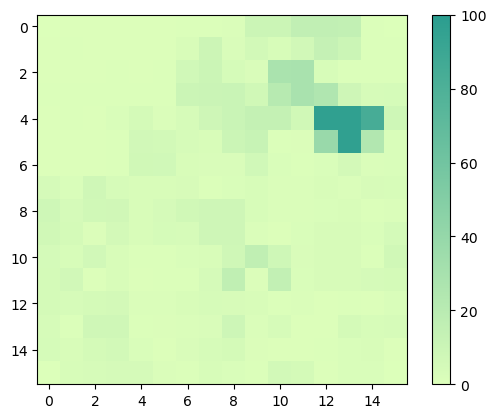

In [16]:
filepath = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP\\20170629_patch2.npy"
filepath_sc = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP\\20170629_patch2_sc.npy"

mtx_f1 = np.load(filepath)
mtx_f1_sc = np.load(filepath_sc)
plt.imshow(mtx_f1, vmin=0, vmax=100, cmap=cm)
plt.colorbar()
plt.show()

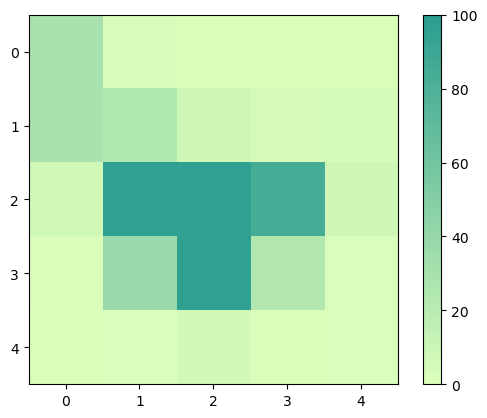

In [17]:
#Exemplary MEA Array
padded_matrix_ejemplo = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
padded_matrix_ejemplo_sc = np.pad(mtx_f1_sc.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
x, y = np.where(padded_matrix_ejemplo==np.nanmax(padded_matrix_ejemplo))
max_f_score_ejemplo = padded_matrix_ejemplo[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]
x, y = np.where(padded_matrix_ejemplo==np.nanmax(padded_matrix_ejemplo))
max_f_score_ejemplo_sc = padded_matrix_ejemplo_sc[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]
plt.imshow(max_f_score_ejemplo, vmin=0, vmax=100, cmap=cm)
plt.colorbar()
plt.show()

In [18]:
dist_1 = [(2, 2)]
dist_2 = [(1, 2), (2, 1), (3, 2), (2, 3)]
dist_3 = [(1, 1), (3, 1), (1, 3), (3, 3)]
dist_4 = [(0, 2),  (2, 0), (4, 2), (2, 4)]
dist_5 = [(0, 1), (1, 0), (0, 3), (3, 0), (1, 4), (4, 1), (4, 3), (3, 4)]
dist_6 = [(0, 0), (4, 0), (0, 4), (4, 4)]
dist_tot = [dist_1, dist_2, dist_3, dist_4, dist_5, dist_6]

In [19]:
dist_ejemplo=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ejemplo[idx].append(max_f_score_ejemplo[int(j[0]), int(j[1])])
        
dist_ejemplo_sc=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ejemplo_sc[idx].append(max_f_score_ejemplo_sc[int(j[0]), int(j[1])])

In [20]:
valores_dist_ejemplo = np.zeros(len(dist_ejemplo))
for i in range(len(dist_ejemplo)):
    aplanado = np.squeeze(dist_ejemplo[i]).flatten()
    valores_dist_ejemplo[i] = np.nanmean(aplanado)
    
valores_dist_ejemplo_sc = np.zeros(len(dist_ejemplo_sc))
for i in range(len(dist_ejemplo_sc)):
    aplanado = np.squeeze(dist_ejemplo_sc[i]).flatten()
    valores_dist_ejemplo_sc[i] = np.nanmean(aplanado)

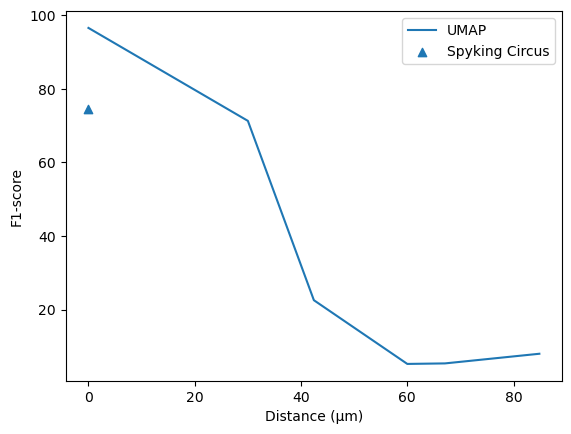

In [20]:
#Exemplary MEA Array
x = [0, 30, 42.42, 60, 67.08, 84.85]
plt.plot(x, valores_dist_ejemplo, label="UMAP")
plt.scatter(x[0], valores_dist_ejemplo_sc[0], label="Spyking Circus", marker='^')
plt.ylabel("F1-score")
plt.xlabel("Distance (μm)")
plt.legend()
plt.show()

In [21]:
filepath = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP"
archivos = np.array([file for file in os.listdir(filepath) if ((file[0] == "2"))])
f_scores_sc = []
f_scores = []
for i in archivos:
    if i[-5]=="c":
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        f_scores_sc.append(padded_matrix)  
    else:
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        f_scores.append(padded_matrix)  

In [22]:
max_f_score = np.zeros((18, 5, 5))
max_f_score_sc = np.zeros((18, 5, 5))
pos_x = []
pos_y = []
pos_x_sc = []
pos_y_sc = []
for idx, i in enumerate(f_scores):
    x, y = np.where(i==np.nanmax(i))
    pos_x.append(x)
    pos_y.append(y)
    max_f_score[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

In [23]:
for idx, i in enumerate(f_scores_sc):
    x, y = np.where(i==np.nanmax(i))
    pos_x_sc.append(x)
    pos_y_sc.append(y)
    max_f_score_sc[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

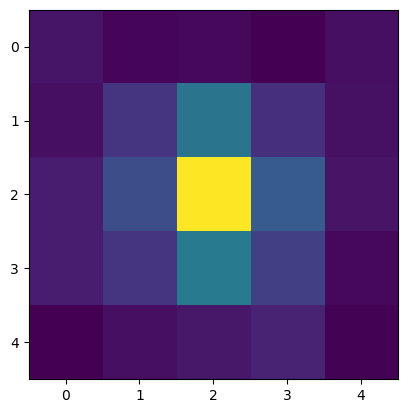

In [24]:
#Average MEA Array (UMAP)
plt.imshow(np.nanmean(max_f_score, 0))
plt.show()

In [25]:
filepath = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP"
archivos = np.array([file for file in os.listdir(filepath) if ((file[0] == "3"))])
precision_scores_sc = []
precision_scores = []
for i in archivos:
    if i[-5]=="c":
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        precision_scores_sc.append(padded_matrix)  
    else:
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        precision_scores.append(padded_matrix)

In [26]:
max_precision_score = np.zeros((18, 5, 5))
max_precision_score_sc = np.zeros((18, 5, 5))
for idx, i in enumerate(precision_scores):
    x, y = pos_x[idx], pos_y[idx]
    max_precision_score[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

In [27]:
for idx, i in enumerate(precision_scores_sc):
    x, y = pos_x_sc[idx], pos_y_sc[idx]
    max_precision_score_sc[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

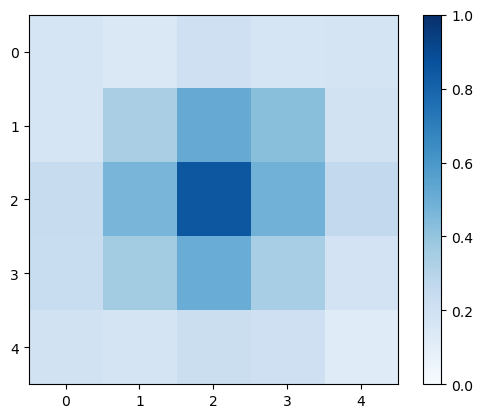

In [28]:
#Average Precision MEA Array (UMAP)
plt.imshow(np.nanmean(max_precision_score/100, 0), vmin=0, vmax=1, cmap="Blues")
plt.colorbar()
plt.show()

In [29]:
#SC Full MEA Precision Average
print(np.amax(np.nanmean(max_precision_score_sc/100, 0)))

0.8043882611328071


In [30]:
max_indv_precision_sc = np.zeros(len(max_precision_score_sc[:-1]))
for idx, i in enumerate(max_precision_score_sc[:-1]):
    max_indv_precision_sc[idx] = np.nanmax(i/100)
print(sem(max_indv_precision_sc))

0.0574582885450703


In [31]:
filepath = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP"
archivos = np.array([file for file in os.listdir(filepath) if ((file[0] == "4"))])
recall_scores_sc = []
recall_scores = []
for i in archivos:
    if i[-5]=="c":
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        recall_scores_sc.append(padded_matrix)  
    else:
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        recall_scores.append(padded_matrix)

In [32]:
max_recall_score = np.zeros((18, 5, 5))
max_recall_score_sc = np.zeros((18, 5, 5))
for idx, i in enumerate(recall_scores):
    x, y = pos_x[idx], pos_y[idx]
    max_recall_score[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

In [33]:
for idx, i in enumerate(recall_scores_sc):
    x, y = pos_x_sc[idx], pos_y_sc[idx]
    max_recall_score_sc[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

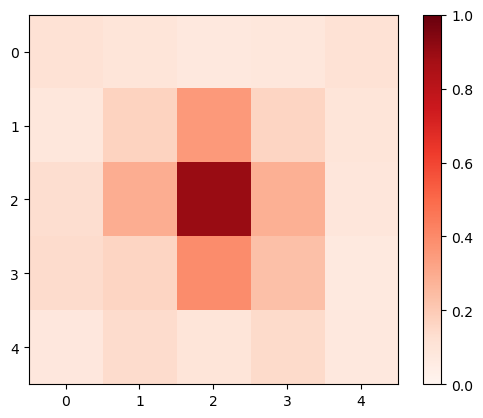

In [34]:
#Average Recall MEA Array (UMAP)
plt.imshow(np.nanmean(max_recall_score/100, 0), vmin=0, vmax=1, cmap="Reds")
plt.colorbar()
#plt.savefig("matrices_promedio_pérdidas (recall).svg")
plt.show()

In [35]:
#SC Full MEA Recall Average
print(np.amax(np.nanmean(max_recall_score_sc/100, 0)))

0.3794399648825436


In [36]:
max_indv_recall_sc = np.zeros(len(max_recall_score_sc[:-1]))
for idx, i in enumerate(max_recall_score_sc[:-1]):
    max_indv_recall_sc[idx] = np.nanmax(i/100)
print(sem(max_indv_recall_sc))

0.04162290672102001


In [37]:
dist_ver_final_2024=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024[idx].append(max_f_score[:, int(j[0]), int(j[1])])

In [38]:
valores_dist = np.zeros(len(dist_ver_final_2024))
desv = np.zeros(len(dist_ver_final_2024))
for i in range(len(dist_ver_final_2024)):
    aplanado = np.squeeze(dist_ver_final_2024[i]).flatten()
    valores_dist[i] = np.nanmean(aplanado)
    desv[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

In [39]:
dist_ver_final_2024_sc=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024_sc[idx].append(max_f_score_sc[:, int(j[0]), int(j[1])])

In [40]:
valores_dist_sc = np.zeros(len(dist_ver_final_2024_sc))
desv_sc = np.zeros(len(dist_ver_final_2024_sc))
for i in range(len(dist_ver_final_2024_sc)):
    aplanado = np.squeeze(dist_ver_final_2024_sc[i]).flatten()
    valores_dist_sc[i] = np.nanmean(aplanado)
    desv_sc[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

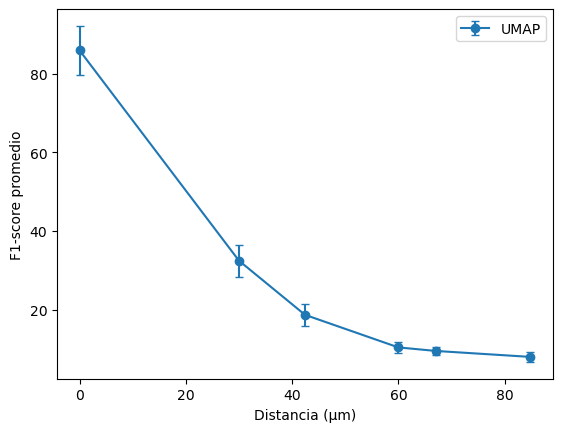

In [41]:
#Average MEA Arrays
x = [0, 30, 42.42, 60, 67.08, 84.85]
plt.errorbar(x, valores_dist, yerr=desv, marker='o', capsize=3, label="UMAP")
plt.ylabel("F1-score promedio")
plt.xlabel("Distancia (μm)")
plt.legend()
plt.show()

In [42]:
dist_ver_final_2024_precision=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024_precision[idx].append(max_precision_score[:, int(j[0]), int(j[1])])

In [43]:
valores_dist_precision = np.zeros(len(dist_ver_final_2024_precision))
desv_precision = np.zeros(len(dist_ver_final_2024_precision))
for i in range(len(dist_ver_final_2024_precision)):
    aplanado = np.squeeze(dist_ver_final_2024_precision[i]).flatten()
    valores_dist_precision[i] = np.nanmean(aplanado)
    desv_precision[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

In [44]:
dist_ver_final_2024_precision_sc=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024_precision_sc[idx].append(max_precision_score_sc[:, int(j[0]), int(j[1])])

In [45]:
valores_dist_precision_sc = np.zeros(len(dist_ver_final_2024_precision_sc))
desv_precision_sc = np.zeros(len(dist_ver_final_2024_precision_sc))
for i in range(len(dist_ver_final_2024_precision_sc)):
    aplanado = np.squeeze(dist_ver_final_2024_precision_sc[i]).flatten()
    valores_dist_precision_sc[i] = np.nanmean(aplanado)
    desv_precision_sc[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

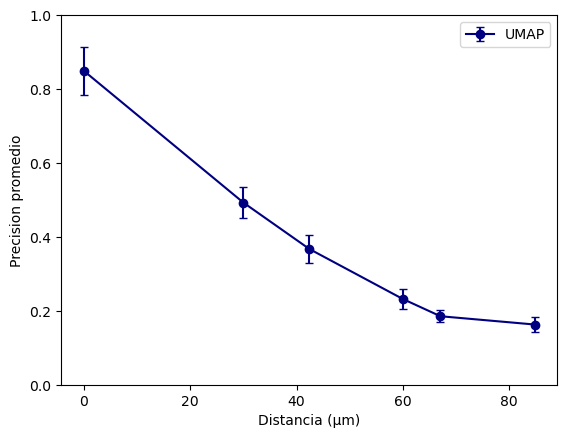

In [46]:
#Average Precision MEA Arrays
x = [0, 30, 42.42, 60, 67.08, 84.85]
plt.errorbar(x, valores_dist_precision/100, yerr=desv_precision/100, marker='o', capsize=3, label="UMAP", color="navy")
plt.ylabel("Precision promedio")
plt.xlabel("Distancia (μm)")
plt.legend()
plt.ylim(0, 1)
plt.show()

In [47]:
dist_ver_final_2024_recall=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024_recall[idx].append(max_recall_score[:, int(j[0]), int(j[1])])

In [48]:
valores_dist_recall = np.zeros(len(dist_ver_final_2024_recall))
desv_recall = np.zeros(len(dist_ver_final_2024_recall))
for i in range(len(dist_ver_final_2024_recall)):
    aplanado = np.squeeze(dist_ver_final_2024_recall[i]).flatten()
    valores_dist_recall[i] = np.nanmean(aplanado)
    desv_recall[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

In [49]:
dist_ver_final_2024_recall_sc=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024_recall_sc[idx].append(max_recall_score_sc[:, int(j[0]), int(j[1])])

In [50]:
valores_dist_recall_sc = np.zeros(len(dist_ver_final_2024_recall_sc))
desv_recall_sc = np.zeros(len(dist_ver_final_2024_recall_sc))
for i in range(len(dist_ver_final_2024_recall_sc)):
    aplanado = np.squeeze(dist_ver_final_2024_recall_sc[i]).flatten()
    valores_dist_recall_sc[i] = np.nanmean(aplanado)
    desv_recall_sc[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

(0.0, 1.0)

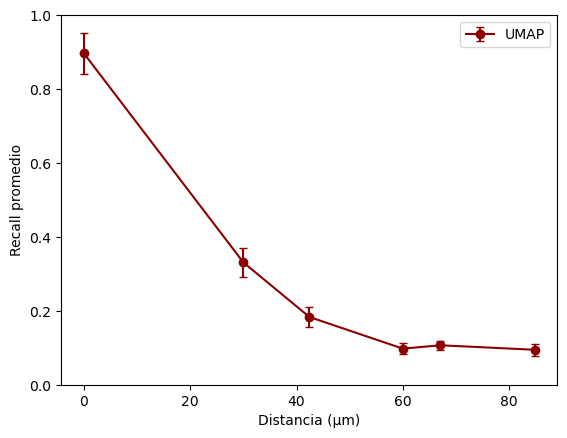

In [51]:
#Average Recall MEA Arrays
x = [0, 30, 42.42, 60, 67.08, 84.85]
plt.errorbar(x, valores_dist_recall/100, yerr=desv_recall/100, marker='o', capsize=3, label="UMAP", color="darkred")
plt.ylabel("Recall promedio")
plt.xlabel("Distancia (μm)")
plt.legend()
plt.ylim(0, 1)

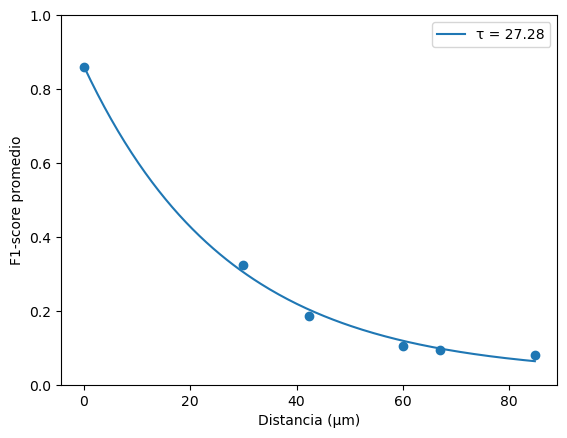

In [52]:
from scipy.optimize import least_squares
def exponencial(x, A, B, tau):
    return A*((np.exp(-(x/tau)))+B)
def residual(params, x, y):
    return exponencial(x, *params)-y
param_ajustados=least_squares(residual, [1, 1, 1], args=(x, valores_dist), jac="cs", loss="linear").x
valores=np.linspace(np.amin(x), np.amax(x), 200)
ajuste=exponencial(valores, *param_ajustados)
plt.scatter(x, valores_dist/100)
plt.plot(valores, ajuste/100, label="τ = {}".format(np.round(param_ajustados[2], 3)))
plt.xlabel("Distancia (μm)")
plt.ylabel("F1-score promedio")
plt.legend()
plt.ylim(0, 1)
plt.show()

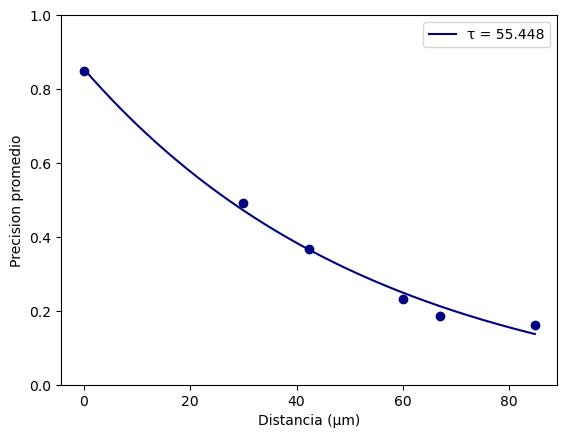

In [53]:
param_ajustados=least_squares(residual, [1, 1, 1], args=(x, valores_dist_precision), jac="cs", loss="linear").x
valores=np.linspace(np.amin(x), np.amax(x), 200)
ajuste=exponencial(valores, *param_ajustados)
plt.scatter(x, valores_dist_precision/100, color="navy")
plt.plot(valores, ajuste/100, color="navy", label="τ = {}".format(np.round(param_ajustados[2], 3)))
plt.xlabel("Distancia (μm)")
plt.ylabel("Precision promedio")
plt.legend()
plt.ylim(0, 1)
plt.show()

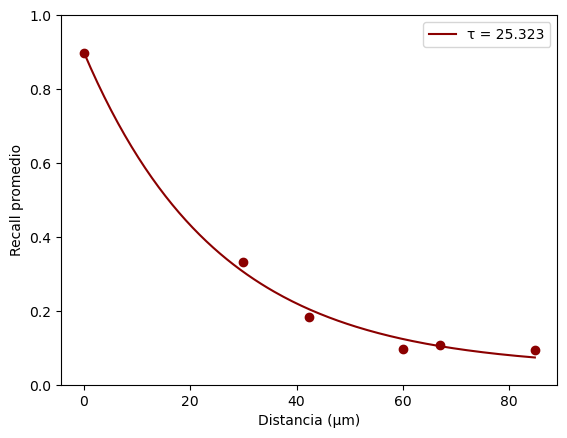

In [54]:
param_ajustados=least_squares(residual, [1, 1, 1], args=(x, valores_dist_recall), jac="cs", loss="linear").x
valores=np.linspace(np.amin(x), np.amax(x), 200)
ajuste=exponencial(valores, *param_ajustados)
plt.scatter(x, valores_dist_recall/100, color="darkred")
plt.plot(valores, ajuste/100, color="darkred", label="τ = {}".format(np.round(param_ajustados[2], 3)))
plt.xlabel("Distancia (μm)")
plt.ylabel("Recall promedio")
plt.legend()
plt.ylim(0, 1)
plt.show()

In [21]:
base = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP"
offsets = [1867, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866]

In [22]:
archivos_todos = os.listdir(base)
UMAP_mtx = np.array([file for file in archivos_todos 
                     if (file[-5] != "c" and file[0] == "2")])

In [23]:
SC_mtx = np.array([file for file in archivos_todos 
                     if (file[-5] == "c" and file[0] == "2")])

In [24]:
#SC Full MEA average
max_f1 = np.zeros(len(SC_mtx))
for i in range(len(SC_mtx)):
    max_f1[i] = np.amax(np.load(SC_mtx[i]))
mean_max = np.mean(max_f1)
print(mean_max)

52.78744559319826


In [25]:
def max_dist(archivo_matriz, paso=30, tolerancia=1e-4, imprimir=True):
    #En cada iteración del while si se imprime la variable "valores" se puede observar 
    #los indices de los electrodos a la misma distancia euclidiana a partir del centraL
    maxima_distancia = 0
    nuevos_cuadros = 1
    matriz = np.load(archivo_matriz)
    pos_max = np.argwhere(matriz == np.max(matriz))[0]
    x, y = pos_max
    idx_centro = matriz_fscore[x][y]

    filas, cols = matriz.shape
    dist_1 = 0
    dist_2 = 0
    distancias = np.array([])
    valoresxdist = []
    while nuevos_cuadros != 0:
        maxima_distancia += 1
        valores = np.array([], dtype=int)
        distancia_real = np.sqrt((dist_1 * paso) ** 2 + (dist_2 * paso) ** 2)
        for a in range(filas):
            for b in range(cols):
                dx = abs(a - x)
                dy = abs(b - y)
                distancia = np.sqrt((dx * paso) ** 2 + (dy * paso) ** 2)
                if abs(distancia - distancia_real) <= tolerancia:
                    if len(np.where(distancias==np.round(distancia_real, 3))[0]) == 0:
                        valores = np.append(valores, matriz_fscore[a, b])
        if len(np.where(distancias==np.round(distancia_real, 3))[0]) == 0:                
            distancias = np.append(distancias, np.round(distancia_real, 3))
            nuevos_cuadros = len(valores)
            valoresxdist.append(valores)
        else:
            nuevos_cuadros = 1
        if dist_1 == dist_2:
            dist_1 += 1
            dist_2 = 0
        else:
            dist_2 += 1
    idxs_dists = np.argsort(distancias)
    dists_sort = []
    for i in idxs_dists:
        dists_sort.append(valoresxdist[i])
    elec_dists = np.array([], dtype=int)
    elec_completo = np.arange(256)
    lista_elec = []
    for i in range(len(dists_sort)):
        elec_dists = np.concatenate((elec_dists, dists_sort[i]))
        lista_elec.append(elec_dists)
        dead_elec = elec_completo[~np.isin(elec_completo, elec_dists)]
        if imprimir == True:
            print(elec_dists)
            print("Round {}".format(i+1))
            print(", ".join(dead_elec.astype(str)))
    return maxima_distancia-1, distancias, lista_elec

In [26]:
def graficarondas(archivo_matriz, offset, tamaño_onda=30):
    
    #Función para extraer espigas
    def extractor(archivo_espigas, archivos_señales, electrodos, tamaño_onda=tamaño_onda):
        ondasxespigaxelectrodo = []
        with h5py.File(archivo_espigas, "r") as f:
            for h, i in enumerate(electrodos):
                señal = archivos_señales[h]
                tiempos_espigas = np.array(f["spiketimes"]["elec_" + str(i)])
                ondasxespiga = np.zeros((len(tiempos_espigas), 2*tamaño_onda+1))
                for j, k in enumerate(tiempos_espigas):
                    ondasxespiga[j]=señal[int(k-tamaño_onda):int(k+tamaño_onda+1)]
                ondasxespigaxelectrodo.append(ondasxespiga)
            return ondasxespigaxelectrodo
    
    #Localizamos centro de la matriz
    matriz = np.load(archivo_matriz)
    pos_max = np.argwhere(matriz == np.max(matriz))[0]
    x, y = pos_max
    idx_centro = matriz_fscore[x][y]
    
    #Cargar espigas de GT
    directorio_inicial = "D:\\MEAs"
    matriz_actual = os.path.join(directorio_inicial, os.path.splitext(os.path.basename(archivo_matriz))[0])
    archivo_espigas_intra = os.path.join(matriz_actual, os.listdir(matriz_actual)[6])
    t_espigas_intra = np.load(archivo_espigas_intra)

    
    #Cargar señales
    intra = [126, 127, 254, 255]
    datos = os.path.join(matriz_actual, os.listdir(matriz_actual)[5])
    data=np.memmap(datos, dtype='uint16', offset=offset, mode='r')
    data=np.array(data.reshape(len(data)//256, 256), dtype="float32").T
    data_alineado = (data - 2**15-1) * 0.1042
    archivos_señales_ext = np.delete(data_alineado, intra, 0)
    
    _, _, electrodos = max_dist(archivo_matriz, imprimir=False)
    electrodos = np.sort(np.where(electrodos[5] > 127, electrodos[5] - 2, electrodos[5]))
    archivos_señales_ext = archivos_señales_ext[electrodos]
        
    #Cargar espigas de cada electrodo 
    carpeta_electrodos = os.path.join(matriz_actual, os.listdir(matriz_actual)[0])
    archivo_espigas_ext = os.path.join(carpeta_electrodos, os.listdir(carpeta_electrodos)[3])
    
    ondas_MEA = extractor(archivo_espigas_ext, archivos_señales_ext, electrodos)
    ondas_sr_ext = []
    for i in ondas_MEA:
        ondas_sr_ext.append(savgol_filter(i, 5, 3))
    
    t_espigas_extra = []
    with h5py.File(archivo_espigas_ext, "r") as f:
        for i in electrodos:
            tiempos_espigas = np.array(f["spiketimes"]["elec_" + str(i)])
            t_espigas_extra.append(tiempos_espigas)
            
    alineadas = []
    for i, j in enumerate(ondas_sr_ext):
        alineadas.append(spike_aligner(j, window_length=30, upsample_rate=8))
        
    reductores= []
    for i in tqdm(alineadas):
        reductores.append(umap.UMAP(min_dist=0, n_neighbors=4, n_components=2, n_epochs=2000, random_state=0, metric="manhattan").fit(i[:, :45]))
    
    clustersxelectrodo = []
    for i in reductores:
        clustersxelectrodo.append(hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(i.embedding_))
    
    labels = []
    for i in clustersxelectrodo:
        labels.append(i.labels_)
    
    ondas_max = []
    for i in range(len(electrodos)):
        fscore_umap = get_precision(t_espigas_extra[i].astype("float64"), labels[i].astype("float64"), t_espigas_intra.astype("float64"))
        if np.sum(fscore_umap) != 0:
            max_fscore_idx = np.argmax(fscore_umap)
            unique_labels = np.unique(labels[i])
            max_label = unique_labels[max_fscore_idx]
            idxs_max_labels = np.where(labels[i]==max_label)[0]
            ondas_max.append(alineadas[i][idxs_max_labels])
            
    return ondas_max

In [338]:
ondasxMEA = []
for i in range(len(UMAP_mtx)):
    ondasxMEA.append(graficarondas(UMAP_mtx[i], offsets[i]))

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
  7%|▋         | 1/15 [00:14<03:26, 14.78s/it]C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
 13%|█▎        | 2/15 [00:15<01:26,  6.63s/it]C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
 20%|██        | 3/15 [00:20<01:06,  5.58s

IndexError: index 252 is out of bounds for axis 0 with size 252

In [27]:
ondasxMEA_extras = [] #This is just the 20170803_patch1
for i in range(16, 17):
    ondasxMEA_extras.append(graficarondas(UMAP_mtx[i], offsets[i]))

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
  4%|▍         | 1/25 [00:43<17:12, 43.02s/it]C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
  8%|▊         | 2/25 [00:53<09:14, 24.10s/it]C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
 12%|█▏        | 3/25 [01:09<07:28, 20.41s

In [28]:
np.save("ondasxMEA_extra", np.asarray(ondasxMEA_extras, dtype=object))

In [29]:
ondasxMEA_extras = np.load("ondasxMEA_extra.npy", allow_pickle=True)

In [131]:
np.save("ondasxMEA5x5", np.asarray(ondasxMEA, dtype=object))

In [120]:
ondasxMEA = np.load("ondasxMEA5x5.npy", allow_pickle=True)

In [31]:
def decaimiento(archivo_matriz):
    mtx_f1 = np.load(archivo_matriz)
    padded_matrix_ejemplo = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
    x, y = np.where(padded_matrix_ejemplo==np.nanmax(padded_matrix_ejemplo))
    max_f_score_ejemplo = padded_matrix_ejemplo[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]
    dist_1 = [(2, 2)]
    dist_2 = [(1, 2), (2, 1), (3, 2), (2, 3)]
    dist_3 = [(1, 1), (3, 1), (1, 3), (3, 3)]
    dist_4 = [(0, 2),  (2, 0), (4, 2), (2, 4)]
    dist_5 = [(0, 1), (1, 0), (0, 3), (3, 0), (1, 4), (4, 1), (4, 3), (3, 4)]
    dist_6 = [(0, 0), (4, 0), (0, 4), (4, 4)]
    dist_tot = [dist_1, dist_2, dist_3, dist_4, dist_5, dist_6]
    dist_ejemplo=[[] for i in range(len(dist_tot))]
    for idx, i in enumerate(dist_tot):
        for j in i:
            dist_ejemplo[idx].append(max_f_score_ejemplo[int(j[0]), int(j[1])])
    valores_dist_ejemplo = np.zeros(len(dist_ejemplo))
    for i in range(len(dist_ejemplo)):
        aplanado = np.squeeze(dist_ejemplo[i]).flatten()
        valores_dist_ejemplo[i] = np.nanmean(aplanado)
    x = [0, 30, 42.42, 60, 67.08, 84.85]
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(x, valores_dist_ejemplo/100)
    ax[0].set_ylabel("sorting quality")
    ax[0].set_xlabel("Distance (μm)")
    im = ax[1].imshow(mtx_f1/100, vmin=0, vmax=1, cmap="Greys")
    fig.colorbar(im)        

In [32]:
def mostrargrafico(archivo_matriz, ondas, ajuste=False, escala="bwr", div=5):
    import matplotlib.cm as cm
    #Localizamos centro de la matriz
    matriz = np.load(archivo_matriz)
    pos_max = np.argwhere(matriz == np.max(matriz))[0]
    x, y = pos_max
    idx_centro = matriz_fscore[x][y]
    _, _, electrodos = max_dist(archivo_matriz, imprimir=False)
    electrodos = np.sort(electrodos[5])
    coords = np.where(np.isin(matriz_fscore, electrodos))
    electrode_loc = np.vstack((coords[0], coords[1])).T
    x_corner, y_corner = electrode_loc[0]
    
    ondas_mtx = np.zeros((len(np.unique(coords[0])), len(np.unique(coords[1])), len(ondas[0][0])))
    colores = np.zeros((len(np.unique(coords[0])), len(np.unique(coords[1])), 4))
    fig, ax = plt.subplots(len(np.unique(coords[0])), len(np.unique(coords[1])), sharex=True, sharey=True)
    wave_min_min = -np.inf 
    wave_min_max = np.inf
    divisiones = np.linspace(0,1,div)
    col_ampl= plt.colormaps[escala](np.linspace(0, 1, div, endpoint=False)[1:])
    #cmap = cm.get_cmap(escala)
    
    minimos = np.zeros((len(np.unique(coords[0])), len(np.unique(coords[1]))))
    #colores_min = np.zeros((len(np.unique(coords[0])), len(np.unique(coords[1])), 4))
    for idx, electrodo in enumerate(electrodos):
        ondas_electrodo = ondas[idx]
        promedio_onda = np.mean(ondas_electrodo, 0)
        x_elec, y_elec = np.argwhere(matriz_fscore==electrodo)[0]
        x_elec, y_elec = x_elec - x_corner, y_elec - y_corner
        ondas_mtx[x_elec, y_elec] = promedio_onda
        if np.min(promedio_onda) < wave_min_max:
            wave_min_max = np.min(promedio_onda)
        elif np.min(promedio_onda) > wave_min_min:
            wave_min_min = np.min(promedio_onda)
        minimos[x_elec, y_elec] = np.min(promedio_onda)
    valores_norm = (minimos - wave_min_min) / (wave_min_max - wave_min_min)
    #colores_rgba = cmap(valores_norm)
    for i in range(div-1):
        idx_colores = np.where((valores_norm>=divisiones[i]) & (valores_norm<=divisiones[i+1]))
        locs = np.vstack((idx_colores[0], idx_colores[1])).T
        colores[locs[:, 0], locs[:, 1]] = col_ampl[i]
    for i in range(len(ondas_mtx)):
        for j in range(len(ondas_mtx[0])):
            #ax[i, j].plot(ondas_mtx[i][j], color=colores_rgba[i][j])
            x_axis = np.arange(0.05, 0.05*62, 0.05)
            ax[i, j].plot(x_axis, ondas_mtx[i][j], color=colores[i][j])
    #for ax in ax.flat:
        #ax.set_axis_off()
    fig.suptitle(f"MEA central waves from {archivo_matriz[:15]}")
    plt.xlabel("Tiempo [ms]")
    plt.savefig(f"MEA_waves_{archivo_matriz[:15]}.svg")

    mtx_f1 = np.load(archivo_matriz)
    padded_matrix_ejemplo = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
    x, y = np.where(padded_matrix_ejemplo==np.nanmax(padded_matrix_ejemplo))
    max_f_score_ejemplo = padded_matrix_ejemplo[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]
    dist_1 = [(2, 2)]
    dist_2 = [(1, 2), (2, 1), (3, 2), (2, 3)]
    dist_3 = [(1, 1), (3, 1), (1, 3), (3, 3)]
    dist_4 = [(0, 2),  (2, 0), (4, 2), (2, 4)]
    dist_5 = [(0, 1), (1, 0), (0, 3), (3, 0), (1, 4), (4, 1), (4, 3), (3, 4)]
    dist_6 = [(0, 0), (4, 0), (0, 4), (4, 4)]
    dist_tot = [dist_1, dist_2, dist_3, dist_4, dist_5, dist_6]
    dist_ejemplo=[[] for i in range(len(dist_tot))]
    for idx, i in enumerate(dist_tot):
        for j in i:
            dist_ejemplo[idx].append(max_f_score_ejemplo[int(j[0]), int(j[1])])
    valores_dist_ejemplo = np.zeros(len(dist_ejemplo))
    for i in range(len(dist_ejemplo)):
        aplanado = np.squeeze(dist_ejemplo[i]).flatten()
        valores_dist_ejemplo[i] = np.nanmean(aplanado)
    x = [0, 30, 42.42, 60, 67.08, 84.85]
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    if ajuste:
        param_ajustados=least_squares(residual, [1, 1, 1], args=(x, valores_dist_ejemplo), jac="cs", loss="linear").x
        valores=np.linspace(np.amin(x), np.amax(x), 200)
        ajuste=exponencial(valores, *param_ajustados)
        ax[0].scatter(x, valores_dist_ejemplo/100, color="black")
        ax[0].plot(valores, ajuste/100, label="τ = {}".format(np.round(param_ajustados[2], 3)), color="darkgrey")
        ax[0].legend()
    ax[0].plot(x, valores_dist_ejemplo/100, color="black")
    ax[0].set_ylabel("sorting quality")
    ax[0].set_xlabel("Distance (μm)")
    ax[0].set_ylim(0, 1.05)
    im = ax[1].imshow(mtx_f1/100, vmin=0, vmax=1, cmap="Purples")
    ax[1].set_ylabel("Y (μm)")
    ax[1].set_xlabel("X (μm)")
    ax[1].set_xticks(np.arange(0, 16, 2), np.arange(0, 16*30, 60))
    ax[1].set_yticks(np.arange(0, 16, 2), np.arange(0, 16*30, 60))
    cbar = fig.colorbar(im) 
    cbar.ax.set_ylabel("F1-score", rotation=-90, labelpad=20) #labelpad separa la etiqueta de los números de la barra
    plt.savefig(f"MEA_performance_{archivo_matriz[:15]}.svg")
    plt.show()

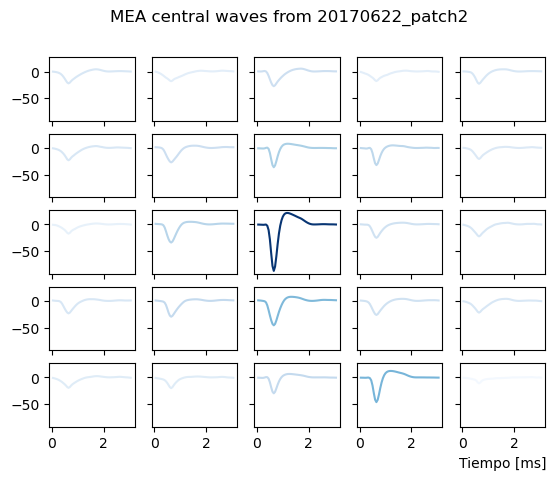

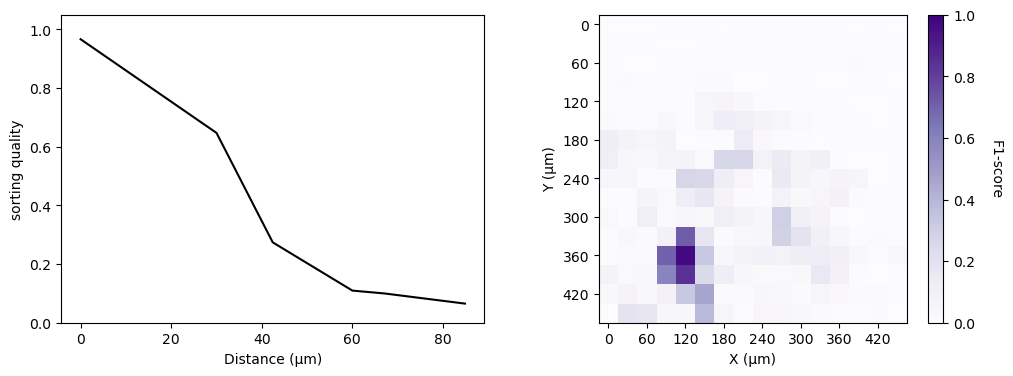

In [124]:
#20170622_patch2, 20170629_patch2, 20170803_patch1
mostrargrafico(UMAP_mtx[3], ondasxMEA[3], escala="Blues", div=51) #3, 6, (16, 5)

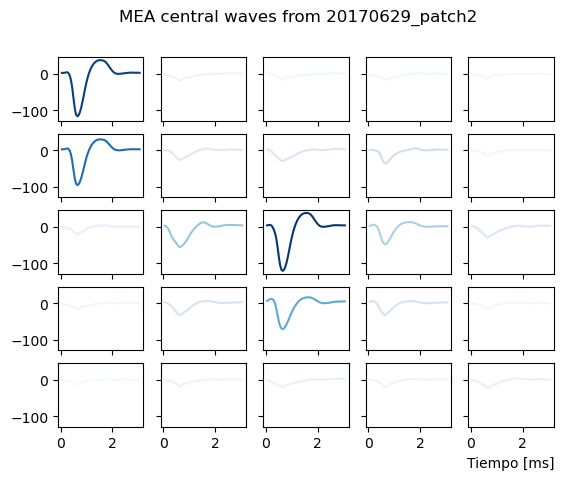

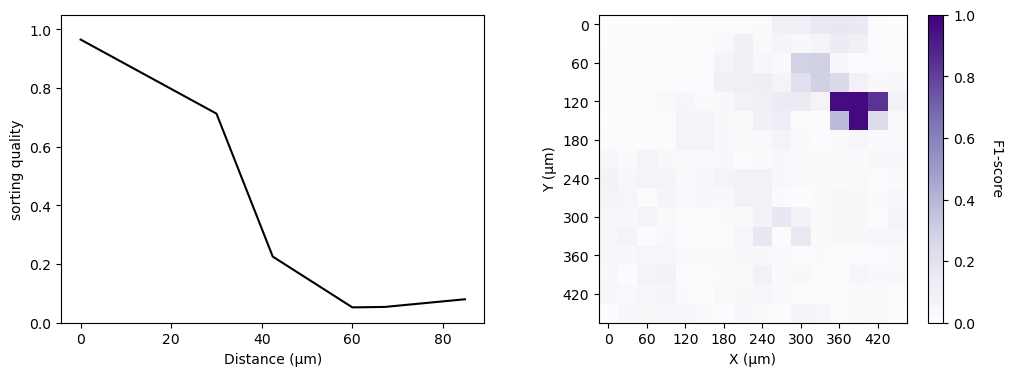

In [123]:
mostrargrafico(UMAP_mtx[6], ondasxMEA[6], escala="Blues", div=51)

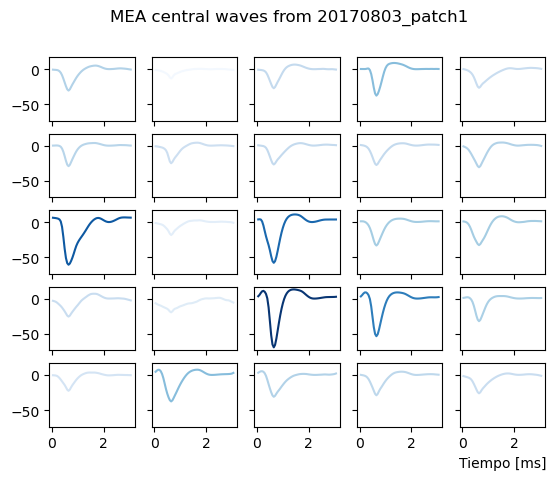

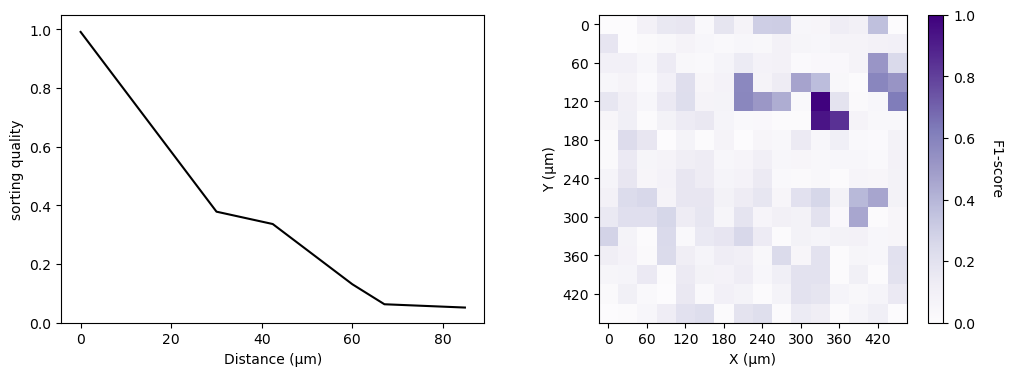

In [33]:
mostrargrafico(UMAP_mtx[16], ondasxMEA_extras[0], escala="Blues", div=51)